    # 0. Install and Import Dependencies

In [101]:
import os
from typing import List

import cv2
import tensorflow as tf
from matplotlib import pyplot as plt

In [102]:

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [103]:
MOUTH_W, MOUTH_H = 70, 35

# 1. Build Data Loading Functions

In [104]:
import numpy as np

cv2_base_dir = os.path.dirname(os.path.abspath(cv2.__file__))
haar_model = os.path.join(cv2_base_dir, 'data/haarcascade_frontalface_default.xml')

lip_cascade = cv2.CascadeClassifier(haar_model)


def mouth_extractor(file_path: str, scale_factor=1.3, min_neighbors=5, mouth_size=(MOUTH_W, MOUTH_H)) -> None:
    base_path = file_path.split('.')[0]
    # if not os.path.exists(base_path + '.npy'):
    if file_path.endswith('.mpg'):
        cap = cv2.VideoCapture(file_path)
        if not cap.isOpened():
            raise Exception("Error: Could not open video.")
        frames = []
        for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
            ret, frame = cap.read()
            if not ret:
                raise Exception("Error: Could not read frame.")
            # Convert to grayscale

            # faces = lip_cascade.detectMultiScale(frame, scale_factor, min_neighbors)
            # if len(faces) == 0:
            #     print(f'Error: No face detected in {file_path}')
            #     continue
            frame = frame[180:250, 100:220, :]
            frame = cv2.resize(frame, mouth_size)
            frame = tf.image.rgb_to_grayscale(frame)
            frames.append(frame)
            # for (x, y, w, h) in faces:
            #     mouth_roi = frame[y + int(h / 2):y + h, x:x + w, :]

            #     frame = tf.image.rgb_to_grayscale(frame)
            #     frames.append(frame)

        cap.release()
        # if len(frames) < 62:
        #     print(f'Error: {file_path} has less than 62 frames,rather drop out', len(frames))
        #     return
        # Normalize frames
        mean = tf.math.reduce_mean(frames)  # compute the mean
        std = tf.math.reduce_std(tf.cast(frames, tf.float32))
        frames_tensor = tf.cast((frames - mean), tf.float32) / std
        # Save as npy file
        np.save(base_path + '.npy', frames_tensor)
        return frames_tensor
    else:
        raise Exception("Error: File format not supported.")


In [105]:
test_path = '/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s1/bbal6n.mpg'
frames = mouth_extractor(test_path)


In [106]:
print(frames.shape)

(75, 35, 70, 1)


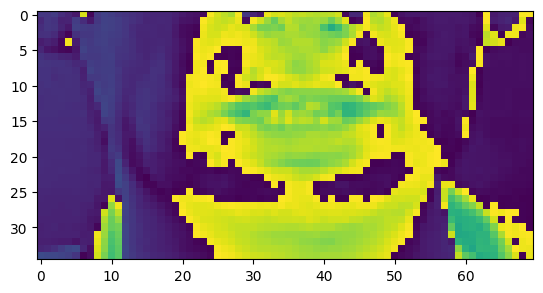

In [107]:
plt.imshow(frames[41][:, :, 0])

In [108]:
import glob
import time

DIR = '/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/'
time1 = time.time()
video_list = glob.glob(DIR + '/**/*.mpg', recursive=True)
# for video in tqdm.tqdm(video_list, total=len(video_list)):
#     mouth_extractor(video)


In [109]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz "]

In [110]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' '] (size =28)


In [111]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 ' ']

In [112]:
char_to_num(['n', 'i', 'c', 'k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [113]:
num_to_char([14, 9, 3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [114]:
# def load_alignments(path:str) -> List[str]: 
#     with open(path, 'r') as f: 
#         lines = f.readlines() 
#     tokens = []
#     for line in lines:
#         line = line.split()
#         if line[2] != 'sil': 
#             tokens = [*tokens,' ',line[2]]
#     return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]
def init_alignments(path: str) -> dict[str:List[str]]:
    alignments = {}
    if not os.path.exists(path):
        raise FileNotFoundError(f'{path} does not exist')
    for file in os.listdir(path):
        if file.endswith('.align'):
            with open(os.path.join(path, file), 'r') as f:
                lines = f.readlines()
            tokens = []
            for line in lines:
                line = line.split()
                if line[2] != 'sil':
                    tokens = [*tokens, ' ', line[2]]
            alignments[file] = char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[
                               1:]
    return alignments


alignments_dict = init_alignments('./data/alignments/s1')


In [115]:
print(len(alignments_dict))

1000


In [116]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    # video_path = f'{file_name}.npy'
    alignment_path = f'{file_name}.align'
    frames = np.load(path, allow_pickle=True)
    alignments = alignments_dict.get(alignment_path)

    return frames, alignments

In [117]:
test_path = '/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s1/bbal6n.npy'

In [118]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [119]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [120]:
print(len(frames))

75


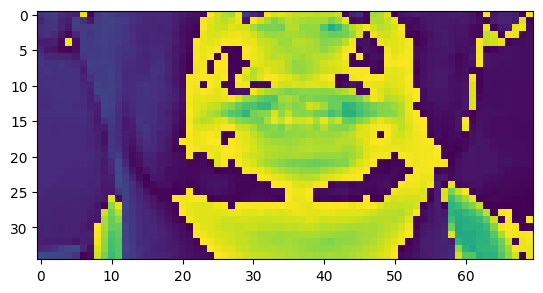

In [121]:
plt.imshow(frames[40][:, :, 0])


In [122]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 27,  2, 12, 21,  5, 27,  1, 20, 27, 12, 27, 19,  9, 24,
       27, 14, 15, 23])>

In [123]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [124]:
def mappable_function(path: str) -> List[str]:
    result = tf.py_function(load_data, [path], (
        tf.float16, tf.int64))  # py_function is used to convert a python function to a tensorflow function
    return result

# 2. Create Data Pipeline

In [168]:
data = tf.data.Dataset.list_files('./data/s1/*.npy')  # list all the files
data = data.shuffle(500, reshuffle_each_iteration=False)  # shuffle is used to shuffle the data
data = data.map(mappable_function)  # 75 frames, 46x140 pixels, 1 channel
data = data.padded_batch(12, padded_shapes=([75, None, None, 1], [37]))  # batch size of 4
data = data.prefetch(tf.data.AUTOTUNE)  # prefetch the data
# Added for split 
train = data.take(80)
test = data.skip(80)

In [169]:
print(len(data))
print(len(train))
print(len(test))

84
80
4


In [127]:
frames, alignments = data.as_numpy_iterator().next()

In [128]:
len(frames)

4

In [129]:
sample = data.as_numpy_iterator()

In [130]:
val = sample.next();
val[0].shape

(4, 75, 35, 70, 1)

In [131]:
# import imageio
# 
# imageio.mimsave('./animation.gif', val[0][0], fps=10)  # can't handle this data type:(1,1,1), <f4
# imageio.mimsave('./animation.gif', val[0][0].astype(np.uint8), fps=10)


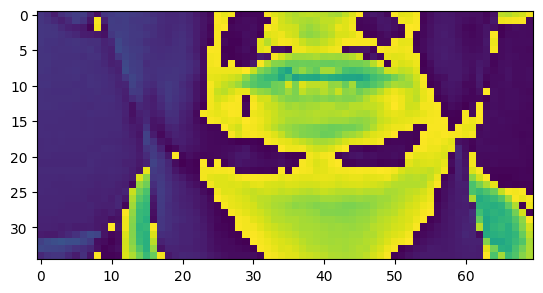

In [132]:
# plt show the image with RGB
#Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
import matplotlib.pyplot as plt

# Assuming `rgb_image` is your numpy array containing RGB values
rgb_image = val[0][0][34][:, :, 0]
plt.imshow(rgb_image)
plt.show()



In [133]:
# calculate the wer and cer
import jiwer


def calculate_wer(true_texts, pred_texts):
    transformation = jiwer.Compose([
        jiwer.ToLowerCase(),
        jiwer.RemoveMultipleSpaces(),
        jiwer.RemovePunctuation(),
        jiwer.Strip(),
        jiwer.ReduceToListOfListOfWords(word_delimiter=" ")
    ])
    wer = jiwer.wer(true_texts, pred_texts, truth_transform=transformation, hypothesis_transform=transformation)
    return wer


def calculate_cer(true_texts, pred_texts):
    transformation = jiwer.Compose([
        jiwer.ToLowerCase(),
        jiwer.RemoveMultipleSpaces(),
        jiwer.RemovePunctuation(),
        jiwer.Strip(),
        jiwer.ReduceToListOfCharacters()
    ])
    cer = jiwer.cer(true_texts, pred_texts, truth_transform=transformation, hypothesis_transform=transformation)
    return cer

In [134]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue at d nine again'>

# 3. Design the Deep Neural Network

In [135]:
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, TimeDistributed, \
    Flatten
from tensorflow.keras.models import Sequential

In [136]:
data.as_numpy_iterator().next()[0][0].shape

(75, 35, 70, 1)

In [138]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75, 35, 70, 1), padding='same'))  # 128 filters, 3x3 kernel
model.add(Activation('relu'))  # activation function
model.add(MaxPool3D((1, 2, 2)))  # max pooling

model.add(Conv3D(256, 3, padding='same'))  # 256 filters, 3x3 kernel
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))  # flatten the output of the previous layer

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))  # bidirectional LSTM
model.add(Dropout(0.5))  # dropout layer

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(
    Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))  # output layer


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 35, 70, 128)   3584      
                                                                 
 activation_3 (Activation)   (None, 75, 35, 70, 128)   0         
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 75, 17, 35, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 17, 35, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 17, 35, 256)   0         
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 75, 8, 17, 256)    0         
 g3D)                                                 

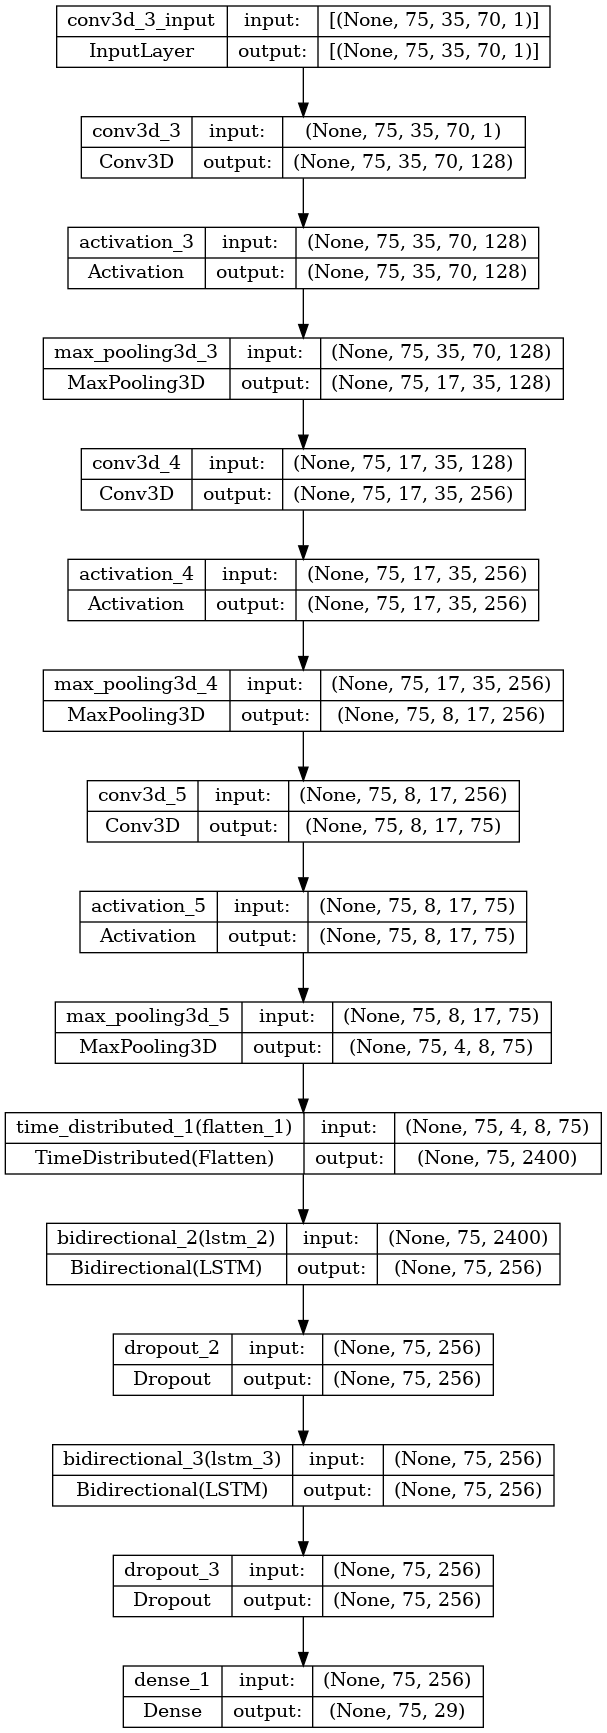

In [139]:
model.summary()
# save as a picture
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='base_line_model_with_layers_70*35.png', show_shapes=True, show_layer_names=True)

In [39]:
8 * 17 * 75

10200

In [140]:
yhat = model.predict(val[0])

1/1 [==============================] - 3s 3s/step


In [141]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0], axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'jjjggjjjjjjjjjjjjjjjjjjjjjjjjjjjggggggggggggggggggggggggggggggggggggggggggu'>

In [142]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'jjjggjjjjjjjjjjjjjjjjjjjjjjjjjjjggggggggggggggggggggggggggggggggggggggggggu'>

In [143]:
model.input_shape

(None, 75, 35, 70, 1)

In [144]:
model.output_shape

(None, 75, 29)

# 4. Setup Training Options and Train

In [145]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [146]:
def scheduler(epoch, lr):  # learning rate scheduler
    if epoch % 10 != 0 or epoch == 0:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [147]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [148]:
from jiwer import wer, cer


class PeriodicWER_CERCallback(tf.keras.callbacks.Callback):
    def __init__(self, train_data, val_data, period=4):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.period = period

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if (epoch + 1) % self.period == 0:  # 每四个epoch计算一次
            train_wer, train_cer = self.compute_wer_cer(self.train_data)
            val_wer, val_cer = self.compute_wer_cer(self.val_data)

            # 更新日志
            logs['train_wer'] = train_wer
            logs['train_cer'] = train_cer
            logs['val_wer'] = val_wer
            logs['val_cer'] = val_cer

            print(
                f"Epoch {epoch + 1}: Train WER: {train_wer:.4f}, Train CER: {train_cer:.4f}, Val WER: {val_wer:.4f}, Val CER: {val_cer:.4f}")

    def compute_wer_cer(self, data):
        # Gather all predictions and true labels
        all_preds, all_trues = [], []
        for batch in data:
            x, y_true = batch
            y_pred = self.model.predict(x)
            decoded_preds, decoded_trues = self.decoded_predictions(y_pred, y_true)
            all_preds.extend(decoded_preds)
            all_trues.extend(decoded_trues)

        # Calculate WER and CER using jiwer
        return wer(all_trues, all_preds), cer(all_trues, all_preds)

    def decoded_predictions(self, yhat, y_true):
        decoded_logits = \
            tf.keras.backend.ctc_decode(yhat, input_length=[75] * len(yhat), greedy=True)[0][0]
        decoded_pred = [tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8') for
                        sentence in decoded_logits]
        decoded_true = [tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8') for
                        sentence in y_true]
        return decoded_pred, decoded_true

# class WER_CERCallback(tf.keras.callbacks.Callback):
#     def __init__(self, train_data, val_data):
#         super().__init__()
#         self.train_data = train_data
#         self.val_data = val_data
# 
#     def on_epoch_end(self, epoch, logs=None):
#         train_wer, train_cer = [], []
#         decoded_pre, decoded_true = self.decoded_predictions(self.model.predict(zip(*self.train_data)[0]),
#                                                              zip(*self.train_data)[1])
#         train_wer.append(wer(decoded_true, decoded_pre))
#         val_wer, val_cer = [], []
#         decoded_pre_val, decoded_true_val = self.decoded_predictions(self.model.predict(zip(*self.val_data)[0]),
#                                                                      zip(*self.val_data)[1])
#         val_wer.append(wer(decoded_true_val, decoded_pre_val))
#         logs['train_wer'] = np.mean(train_wer)
#         logs['train_cer'] = np.mean(train_cer)
#         logs['val_wer'] = np.mean(val_wer)
#         logs['val_cer'] = np.mean(val_cer)
#         print(f'Train WER: {train_wer}, Train CER: {train_cer},', f'Val WER: {val_wer}, Val CER: {val_cer}')
#         tf.summary.scalar('train_wer', data=train_wer, step=epoch)
#         tf.summary.scalar('train_cer', data=train_cer, step=epoch)
#         tf.summary.scalar('val_wer', data=val_wer, step=epoch)
#         tf.summary.scalar('val_cer', data=val_cer, step=epoch)
# 
#     def decoded_predictions(self, yhat, y_true):
#         decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75] * len(yhat), greedy=True)[0][0].numpy()
#         decoded_pred = [tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8') for
#                         sentence in decoded]
#         decoded_true = [tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8') for
#                         sentence in y_true]
#         return decoded_pred, decoded_true








In [171]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)
model.load_weights('models/lip_reading_baseline_70*35.h5')

In [172]:
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'lip_reading_baseline_70*35.h5'), monitor='val_loss',
                                      save_weights_only=True, save_freq=1, )

In [173]:
schedule_callback = LearningRateScheduler(scheduler)
wer_cer_callback = PeriodicWER_CERCallback(train, test, 4)

In [174]:
from datetime import datetime

log_dir = "logs/fit/" + datetime.now().strftime("%Y-%m-%d-%H%M")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [175]:
model.fit(train, validation_data=test, epochs=100,
          callbacks=[checkpoint_callback, schedule_callback, wer_cer_callback, tensorboard_callback])

# caculate the loss

Epoch 1/100
80/80 [==============================] - 52s 439ms/step - loss: 67.9546 - val_loss: 68.6930 - lr: 1.0000e-04
Epoch 2/100
80/80 [==============================] - 35s 432ms/step - loss: 66.5042 - val_loss: 67.8359 - lr: 1.0000e-04
Epoch 3/100
80/80 [==============================] - 34s 429ms/step - loss: 64.7120 - val_loss: 64.5231 - lr: 1.0000e-04
Epoch 4/100
1/1 [==============================] - 0s 38ms/step
Epoch 4: Train WER: 0.9931, Train CER: 0.7999, Val WER: 1.0000, Val CER: 0.7926
80/80 [==============================] - 119s 1s/step - loss: 63.1072 - val_loss: 62.9274 - lr: 1.0000e-04 - train_wer: 0.9931 - train_cer: 0.7999 - val_wer: 1.0000 - val_cer: 0.7926
Epoch 5/100
80/80 [==============================] - 34s 431ms/step - loss: 61.9120 - val_loss: 61.8619 - lr: 1.0000e-04
Epoch 6/100
80/80 [==============================] - 34s 428ms/step - loss: 60.4333 - val_loss: 59.9434 - lr: 1.0000e-04
Epoch 7/100
80/80 [==============================] - 34s 431ms/step 

In [176]:
# model.evaluate(test)
loss_history = model.history.history

dict_keys(['loss', 'val_loss', 'lr', 'train_wer', 'train_cer', 'val_wer', 'val_cer'])


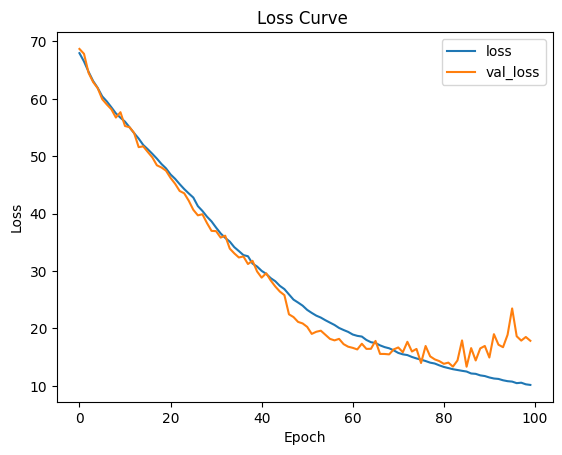

In [177]:
# draw the loss curve
print(loss_history.keys())
plt.plot(loss_history['loss'], label='loss')
plt.plot(loss_history['val_loss'], label='val_loss')
# plt.plot(loss_history['train_wer'], label='train_wer')
# plt.plot(loss_history['train_cer'], label='train_cer')
# x label and y label
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve ')
plt.legend(loc='upper right')
filename = 'loss_curve_70*35.png'
plt.savefig(filename)
plt.show()


# 5. Make a Prediction 

In [ ]:
# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# output = 'checkpoints.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('checkpoints.zip', 'models')

In [179]:
model.load_weights('models/lip_reading_baseline_70*35.h5')


In [181]:
## test on the test data
test_loss = model.evaluate(test)
print(f'Baseline The Test loss: {test_loss}')
# accuracy
accuracy = 100 - test_loss
print(f'Baseline Test accuracy: {accuracy}')
# test on the train data
train_loss = model.evaluate(train)
print(f'Baseline The Train loss: {train_loss}')


4/4 [==============================] - 1s 93ms/step - loss: 6.9864
Baseline The Test loss: 6.986403942108154
Baseline Test accuracy: 93.01359605789185
80/80 [==============================] - 10s 123ms/step - loss: 7.5191
Baseline The Train loss: 7.519130229949951


In [182]:
test_data = test.as_numpy_iterator()

In [183]:
sample = test_data.next()

In [184]:
yhat = model.predict(sample[0])

1/1 [==============================] - 1s 668ms/step


In [185]:
print('~' * 100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place red with q three soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set blue at a six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place red at c eight please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin red in s three soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay red in k three soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay white at e nine soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green with z zero please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin white in g zero now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin white at t three soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay green with t three again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at z five soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place blue with d one again'>]

In [186]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75] * len(yhat), greedy=True)[0][0].numpy()

In [187]:
print('~' * 100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place red with thre son'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set blue at six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place red at eight please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin red in thre soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay red in thre son'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay white at ne soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green with zro please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin white in zero now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin white at thre soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay green with the again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at five son'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place blue with one again'>]

# Test on a Video

In [188]:
sample = load_data(tf.convert_to_tensor('./data/s1/bbal6n.npy'))

In [189]:
print('~' * 100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>]

In [190]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 668ms/step


In [191]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [192]:
print('~' * 100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at six now'>]